Matplotlib is building the font cache; this may take a moment.


=== ETH Price Movement Analysis ===
----------------------------------
Loading swap data from swap_events_1d.csv...
Loaded 6687 valid swap events with sqrtPriceX96 values
Calculating ETH prices from sqrtPriceX96 values...

ETH price range: $1836.81 - $1940.66
Mean price: $1892.10

Identifying directional price movements (method: peaks)...
Parameters: min_change_threshold=0.01%, smoothing_window=5
Identified 523 directional price movements
Mean absolute price change: 0.1202%
Median absolute price change: 0.0829%
Max absolute price change: 1.1494%

Creating visualizations...


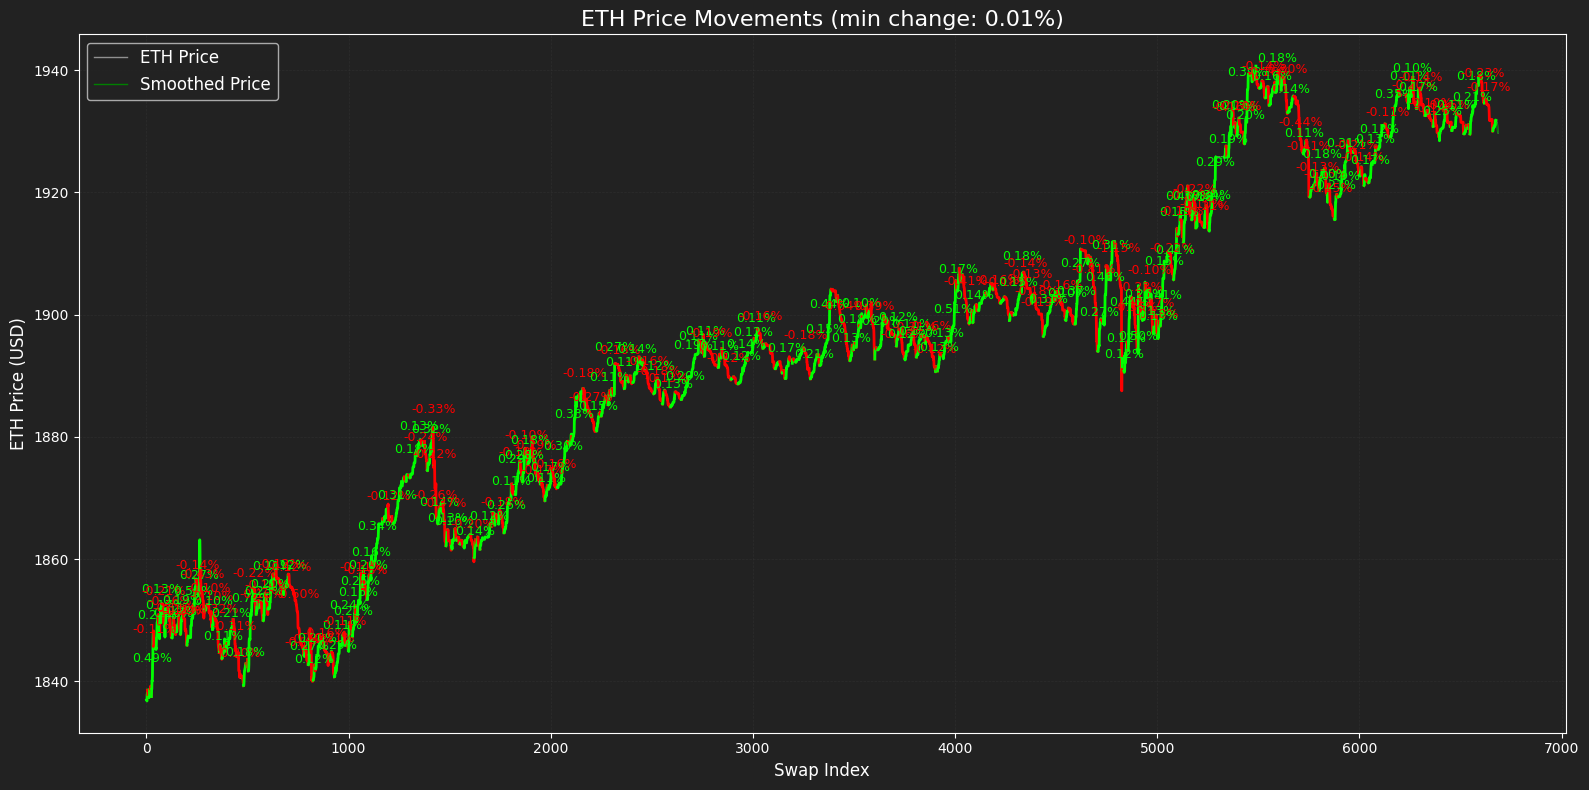

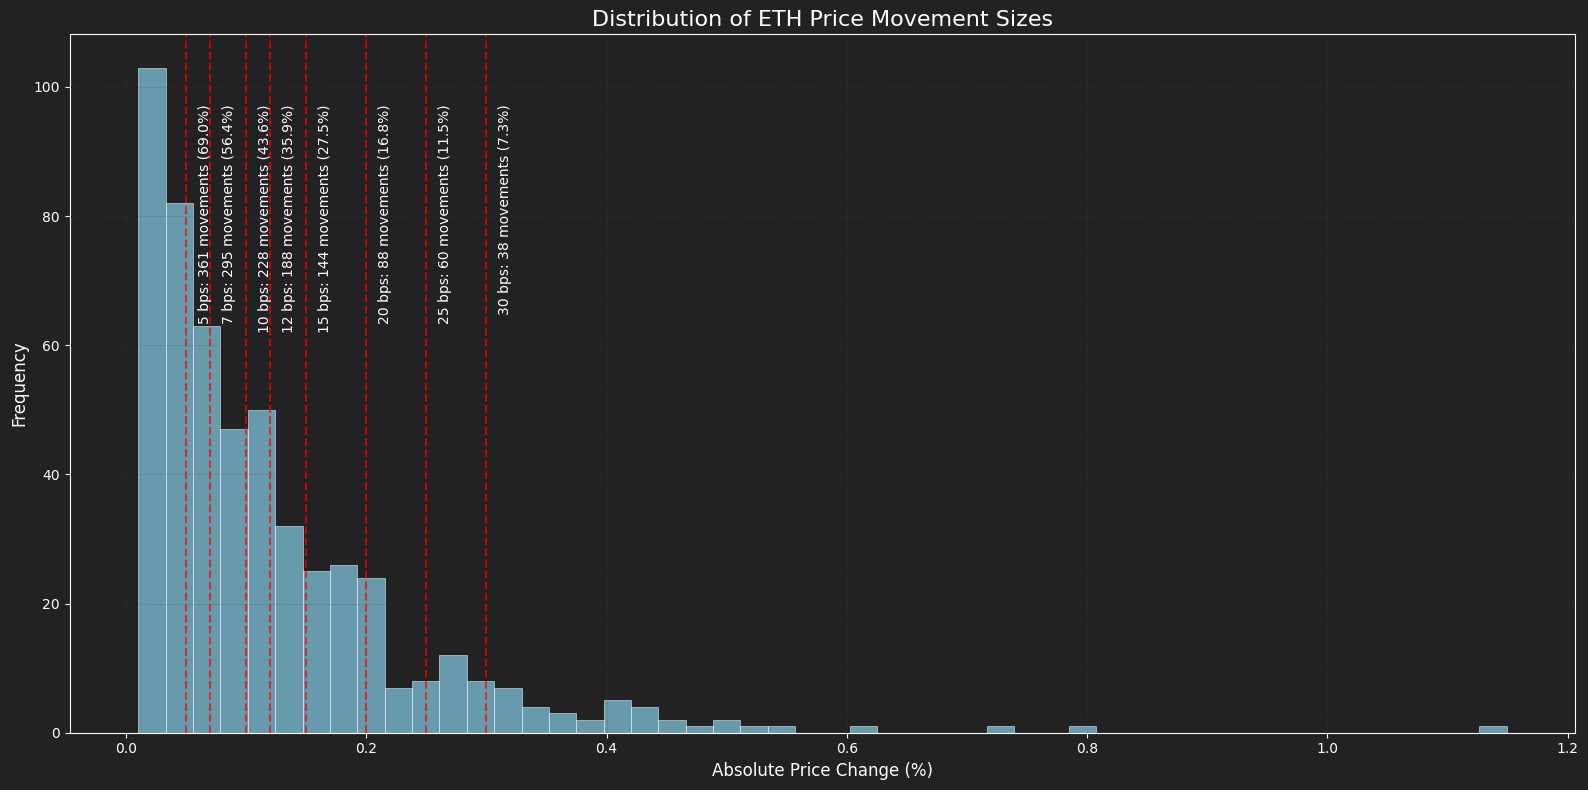


Fee tier analysis:
5.0 bps tier: 523.0 movements (100.0% of total)
  Estimated volume: $62841315.42, fees: $31420.66
7.0 bps tier: 485.0 movements (92.7% of total)
  Estimated volume: $52579719.32, fees: $36805.80
10.0 bps tier: 361.0 movements (69.0% of total)
  Estimated volume: $40151841.53, fees: $40151.84
12.0 bps tier: 295.0 movements (56.4% of total)
  Estimated volume: $33622585.73, fees: $40347.10
15.0 bps tier: 228.0 movements (43.6% of total)
  Estimated volume: $25776196.72, fees: $38664.30
20.0 bps tier: 144.0 movements (27.5% of total)
  Estimated volume: $16831548.77, fees: $33663.10
25.0 bps tier: 88.0 movements (16.8% of total)
  Estimated volume: $11099635.62, fees: $27749.09
30.0 bps tier: 60.0 movements (11.5% of total)
  Estimated volume: $7596513.41, fees: $22789.54


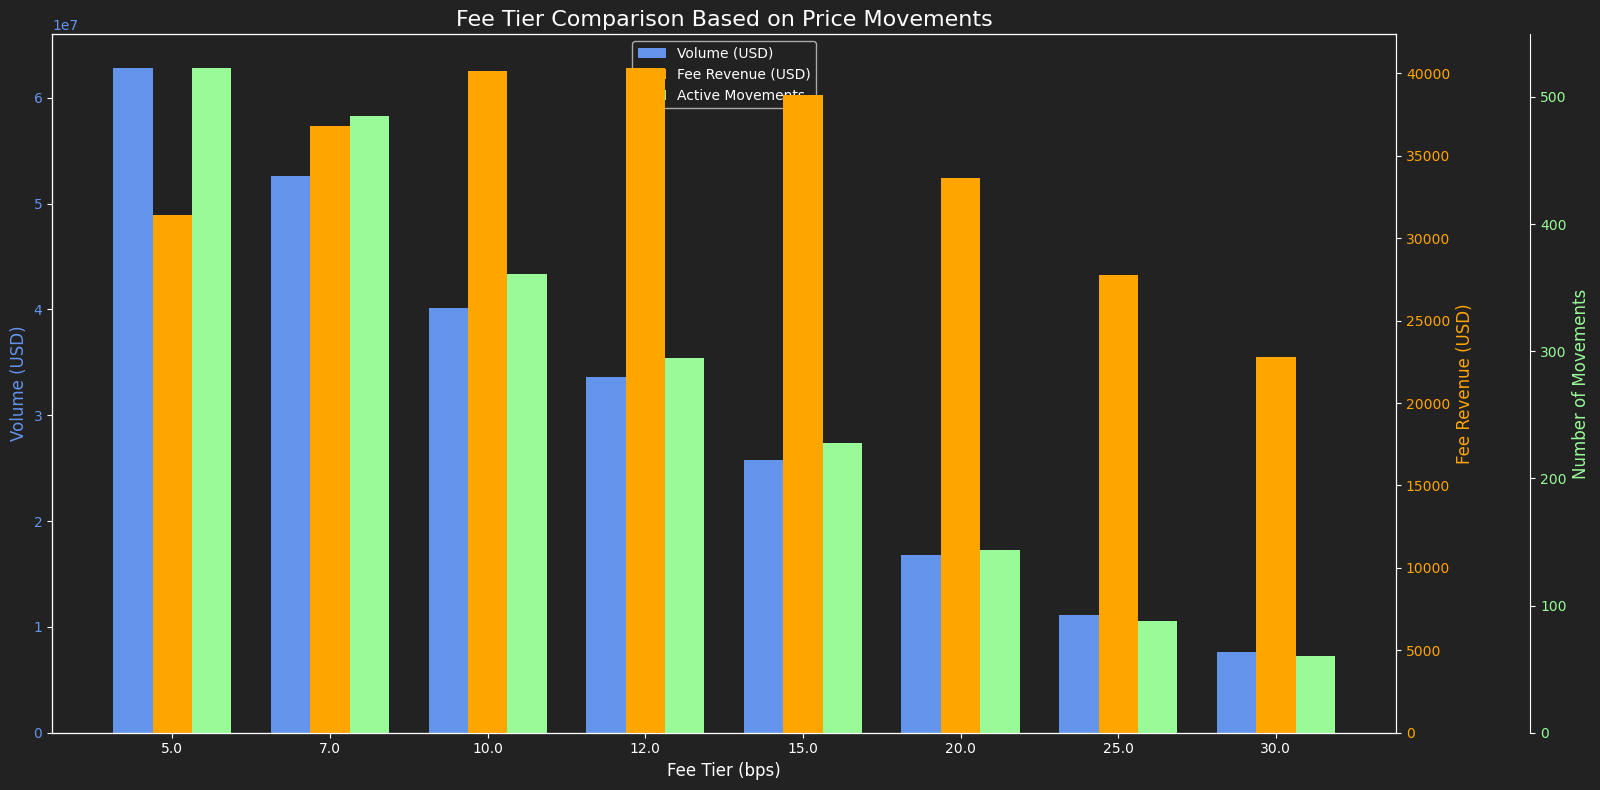


Analysis complete!

=== Detailed Movement Analysis ===
Total movements: 523
Upward movements: 273
Downward movements: 250

Movement size distribution:
0.03-0.05%: 74 movements (14.1%)
0.05-0.1%: 133 movements (25.4%)
0.1-0.2%: 140 movements (26.8%)
0.2-0.5%: 81 movements (15.5%)
0.5-1.0%: 6 movements (1.1%)
1.0%+: 1 movements (0.2%)

Largest price movements:
Movement from $1911.90 to $1889.93: -1.1494% (down)
Movement from $1909.38 to $1893.99: -0.8062% (down)
Movement from $1842.06 to $1855.40: 0.7242% (up)
Movement from $1855.41 to $1844.23: -0.6027% (down)
Movement from $1902.87 to $1892.59: -0.5402% (down)

=== Fee Tier Optimization ===
Optimal fee tier for revenue: 12.0 bps
Estimated daily volume: $33622585.73
Estimated daily fees: $40347.10
Active price movements: 295.0 (56.4% of total)


In [1]:
# ETH Price Movement Analysis - Directional Changes Across Fee Tiers
# ----------------------------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import math
from typing import List, Dict, Tuple, Optional
from scipy.signal import find_peaks

# Set plotting style for dark background
plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['axes.facecolor'] = '#222222'
plt.rcParams['figure.facecolor'] = '#222222'
plt.rcParams['grid.color'] = '#444444'
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.linewidth'] = 0.5

# -------------------- DATA LOADING AND PREPROCESSING --------------------

def load_eth_usdc_swaps(file_path: str) -> pd.DataFrame:
    """
    Load ETH-USDC swap data from CSV file
    """
    try:
        # Load CSV file
        df = pd.read_csv(file_path)
        
        # Check if the dataframe is empty
        if df.empty:
            print("CSV file is empty!")
            return pd.DataFrame()
        
        # Convert block number to numeric if it's not already
        if 'metadata/blockNumber' in df.columns:
            df['block_number'] = pd.to_numeric(df['metadata/blockNumber'], errors='coerce')
        else:
            print("Warning: blockNumber column not found!")
            
        # Extract transaction hash
        if 'metadata/transactionHash' in df.columns:
            df['transaction_hash'] = df['metadata/transactionHash']
        else:
            print("Warning: transactionHash column not found!")
            
        # Extract sqrtPriceX96
        if 'event/sqrtPriceX96' in df.columns:
            df['sqrtPriceX96'] = df['event/sqrtPriceX96']
        else:
            print("Warning: sqrtPriceX96 column not found!")
            
        # Add swap info
        if 'event/tokenIn' in df.columns and 'event/tokenOut' in df.columns:
            df['token_in'] = df['event/tokenIn']
            df['token_out'] = df['event/tokenOut']
            
            # Extract amounts
            df['amount_in'] = pd.to_numeric(df['event/amountIn'], errors='coerce')
            df['amount_out'] = pd.to_numeric(df['event/amountOut'], errors='coerce')
        else:
            print("Warning: Token or amount columns not found!")
         
        # Sort by block number
        df = df.sort_values('block_number')
        
        # Drop rows with missing sqrtPriceX96
        if 'sqrtPriceX96' in df.columns:
            df = df.dropna(subset=['sqrtPriceX96'])
            print(f"Loaded {len(df)} valid swap events with sqrtPriceX96 values")
        
        return df
        
    except Exception as e:
        print(f"Error loading swap data: {e}")
        # Return an empty DataFrame
        return pd.DataFrame()

def calculate_prices_from_sqrt_price(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate ETH-USDC prices from sqrtPriceX96 values.
    For ETH-USDC pool where USDC (6 decimals) is token0 and WETH (18 decimals) is token1.
    """
    # Make a copy to avoid modifying the original
    result_df = df.copy()
    
    # Calculate prices using sqrtPriceX96
    def calculate_price_from_sqrtprice(sqrtPriceX96):
        """
        Calculate price from sqrtPriceX96 using the Uniswap V3 pricing formula
        
        Parameters:
        -----------
        sqrtPriceX96 : float or str
            Square root of price * 2^96
        
        Returns:
        --------
        float
            Price of ETH in USDC
        """
        if not sqrtPriceX96 or pd.isna(sqrtPriceX96):
            return None
            
        try:
            # Convert to float and handle scientific notation
            sqrtPrice = float(sqrtPriceX96)
            
            # Uniswap V3 price calculation
            # Price = (sqrtPriceX96 / 2^96)^2 * (10^token1Decimals / 10^token0Decimals)
            # Assuming WETH (token0) has 18 decimals and USDC (token1) has 6 decimals
            price = (sqrtPrice / (2**96))**2 * (10**6 / 10**18)
            
            # Invert to get USDC per ETH
            price_usdc_per_eth = 1 / price
            
            return round(price_usdc_per_eth, 2)
        except Exception as e:
            # Silently handle errors
            return None
    
    # Apply the calculation to each row
    result_df['eth_price_usd'] = result_df['sqrtPriceX96'].apply(calculate_price_from_sqrtprice)
    
    # Print just the overall statistics, not individual calculations
    valid_prices = result_df['eth_price_usd'].dropna()
    if not valid_prices.empty:
        print(f"\nETH price range: ${valid_prices.min():.2f} - ${valid_prices.max():.2f}")
        print(f"Mean price: ${valid_prices.mean():.2f}")
    else:
        print("No valid prices calculated.")
    
    # Filter out rows with invalid prices
    result_df = result_df.dropna(subset=['eth_price_usd'])
    
    # Calculate price changes
    result_df['price_change_pct'] = result_df['eth_price_usd'].pct_change() * 100
    
    return result_df

# -------------------- PRICE MOVEMENT IDENTIFICATION --------------------

def identify_directional_price_movements(
    price_data: pd.DataFrame, 
    min_change_threshold: float = 0.01,  # Minimum percentage change to consider
    smoothing_window: int = 1,  # Number of points for smoothing (1 = no smoothing)
    method: str = 'peaks'  # 'direction_change' or 'peaks'
) -> pd.DataFrame:
    """
    Identify significant directional price movements in the data.
    
    Args:
        price_data: DataFrame with 'eth_price_usd' column
        min_change_threshold: Minimum percentage change to consider a movement significant
        smoothing_window: Size of rolling window for price smoothing 
        method: 'direction_change' or 'peaks' - algorithm to use
        
    Returns:
        DataFrame with identified price movements
    """
    # Create a copy of the price data
    df = price_data.copy()
    
    # Apply optional smoothing
    if smoothing_window > 1:
        df['smooth_price'] = df['eth_price_usd'].rolling(window=smoothing_window, center=True).mean()
        # Fill NaN values at the beginning and end
        df['smooth_price'] = df['smooth_price'].fillna(df['eth_price_usd'])
    else:
        df['smooth_price'] = df['eth_price_usd']
    
    movements = []
    
    if method == 'direction_change':
        # Method 1: Identify movements by direction changes
        # Initialize variables to track the current trend
        current_direction = None
        start_index = 0
        
        for i in range(1, len(df)):
            # Determine the current direction
            if df['smooth_price'].iloc[i] > df['smooth_price'].iloc[i-1]:
                new_direction = 'up'
            elif df['smooth_price'].iloc[i] < df['smooth_price'].iloc[i-1]:
                new_direction = 'down'
            else:
                new_direction = current_direction  # No change
            
            # Check if direction has changed or we've reached the end
            if new_direction != current_direction and current_direction is not None:
                # Calculate the movement
                start_price = df['smooth_price'].iloc[start_index]
                end_price = df['smooth_price'].iloc[i-1]
                pct_change = (end_price - start_price) / start_price * 100
                
                # Only record significant movements
                if abs(pct_change) >= min_change_threshold:
                    movements.append({
                        'start_index': start_index,
                        'end_index': i-1,
                        'start_price': start_price,
                        'end_price': end_price,
                        'pct_change': pct_change,
                        'direction': current_direction,
                        'start_block': df['block_number'].iloc[start_index] if 'block_number' in df.columns else None,
                        'end_block': df['block_number'].iloc[i-1] if 'block_number' in df.columns else None,
                    })
                
                # Reset for the next movement
                start_index = i-1
            
            current_direction = new_direction
        
        # Add the final movement if significant
        if current_direction is not None:
            end_index = len(df) - 1
            start_price = df['smooth_price'].iloc[start_index]
            end_price = df['smooth_price'].iloc[end_index]
            pct_change = (end_price - start_price) / start_price * 100
            
            if abs(pct_change) >= min_change_threshold:
                movements.append({
                    'start_index': start_index,
                    'end_index': end_index,
                    'start_price': start_price,
                    'end_price': end_price,
                    'pct_change': pct_change,
                    'direction': current_direction,
                    'start_block': df['block_number'].iloc[start_index] if 'block_number' in df.columns else None,
                    'end_block': df['block_number'].iloc[end_index] if 'block_number' in df.columns else None,
                })
    
    elif method == 'peaks':
        # Method 2: Use peak detection to find local maxima and minima
        # Find peaks (local maxima)
        prices = df['smooth_price'].values
        peak_indices, _ = find_peaks(prices)
        # Find valleys (local minima) by inverting the curve
        valley_indices, _ = find_peaks(-prices)
        
        # Combine peaks and valleys and sort by index
        all_extrema = sorted(list(peak_indices) + list(valley_indices))
        
        if len(all_extrema) > 1:
            # Process consecutive extrema to define movements
            for i in range(len(all_extrema) - 1):
                start_index = all_extrema[i]
                end_index = all_extrema[i + 1]
                
                start_price = df['smooth_price'].iloc[start_index]
                end_price = df['smooth_price'].iloc[end_index]
                pct_change = (end_price - start_price) / start_price * 100
                
                # Only record significant movements
                if abs(pct_change) >= min_change_threshold:
                    direction = 'up' if end_price > start_price else 'down'
                    movements.append({
                        'start_index': start_index,
                        'end_index': end_index,
                        'start_price': start_price,
                        'end_price': end_price,
                        'pct_change': pct_change,
                        'direction': direction,
                        'start_block': df['block_number'].iloc[start_index] if 'block_number' in df.columns else None,
                        'end_block': df['block_number'].iloc[end_index] if 'block_number' in df.columns else None,
                    })
    
    # Convert to DataFrame
    movements_df = pd.DataFrame(movements)
    
    if not movements_df.empty:
        # Calculate number of swaps involved in each movement
        movements_df['num_swaps'] = movements_df['end_index'] - movements_df['start_index'] + 1
        
        # Add derived statistics
        movements_df['abs_pct_change'] = movements_df['pct_change'].abs()
        
        # Sort by start index
        movements_df = movements_df.sort_values('start_index')
        
        print(f"Identified {len(movements_df)} directional price movements")
        print(f"Mean absolute price change: {movements_df['abs_pct_change'].mean():.4f}%")
        print(f"Median absolute price change: {movements_df['abs_pct_change'].median():.4f}%")
        print(f"Max absolute price change: {movements_df['abs_pct_change'].max():.4f}%")
    else:
        print("No significant price movements identified with current parameters")
    
    return movements_df

# -------------------- FEE TIER ANALYSIS --------------------


def simulate_fee_tier_movements(
    movements_df: pd.DataFrame,
    fee_tiers_bps: List[float] = [5, 7, 10, 12, 15, 20, 25, 30],
    base_fee_bps: float = 5.0,  # Base fee tier (usually 5bps)
    volume_scaling_factor: float = 1000000  # Scaling factor for volume calculations
) -> pd.DataFrame:
    """
    Analyze which price movements would trigger trades across different fee tiers.
    
    Args:
        movements_df: DataFrame with price movements
        fee_tiers_bps: List of fee tiers in basis points to analyze
        base_fee_bps: The base fee tier that original data comes from
        volume_scaling_factor: Scaling factor for volume estimations
        
    Returns:
        DataFrame with analysis results for each fee tier
    """
    if movements_df.empty:
        print("No price movements to analyze")
        return pd.DataFrame()
    
    results = []
    base_movement_count = len(movements_df)
    base_fee_pct = base_fee_bps / 100
    
    for fee_bps in fee_tiers_bps:
        # Convert fee from bps to percentage
        fee_pct = fee_bps / 100
        
        if fee_bps == base_fee_bps:
            # For the base tier, all movements are active
            active_movements = movements_df.copy()
            # Effective percentage change is the actual change
            active_movements['effective_pct_change'] = active_movements['abs_pct_change']
        else:
            # For higher tiers, calculate the "total economic force" behind each movement
            # This is the observed change plus the base fee
            movements_df['total_economic_force'] = movements_df['abs_pct_change'] + base_fee_pct
            
            # A movement triggers a trade in a higher tier if the total economic force exceeds that tier's fee
            active_movements = movements_df[movements_df['total_economic_force'] > fee_pct].copy()
            
            # Calculate the effective percentage change after accounting for the fee differential
            active_movements['effective_pct_change'] = active_movements['abs_pct_change'] - (fee_pct - base_fee_pct)
        
        # Calculate total volume based on the effective percentage changes
        total_effective_pct = active_movements['effective_pct_change'].sum()
        estimated_volume = total_effective_pct * volume_scaling_factor
        
        # Calculate fee revenue
        fee_revenue = estimated_volume * (fee_pct / 100)
        
        # Store results
        results.append({
            'fee_tier_bps': fee_bps,
            'fee_percentage': fee_pct,
            'active_movements': len(active_movements),
            'movement_capture_pct': len(active_movements) / base_movement_count * 100,
            'avg_movement_size': active_movements['abs_pct_change'].mean() if not active_movements.empty else 0,
            'total_effective_pct': total_effective_pct,
            'estimated_volume_usd': estimated_volume,
            'estimated_fees_usd': fee_revenue
        })
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    print("\nFee tier analysis:")
    for _, row in results_df.iterrows():
        print(f"{row['fee_tier_bps']} bps tier: {row['active_movements']} movements "
              f"({row['movement_capture_pct']:.1f}% of total)")
        print(f"  Estimated volume: ${row['estimated_volume_usd']:.2f}, "
              f"fees: ${row['estimated_fees_usd']:.2f}")
    
    return results_df

# -------------------- VISUALIZATION FUNCTIONS --------------------

def plot_price_movements(
    price_data: pd.DataFrame,
    movements_df: pd.DataFrame,
    title: str = "ETH Price Movements"
) -> None:
    """
    Plot ETH price with identified directional movements.
    
    Args:
        price_data: DataFrame with 'eth_price_usd' column
        movements_df: DataFrame with identified price movements
        title: Plot title
    """
    plt.figure(figsize=(16, 8))
    
    # Plot the full price series
    plt.plot(price_data.index, price_data['eth_price_usd'], 'w-', alpha=0.5, linewidth=1, label='ETH Price')
    
    if 'smooth_price' in price_data.columns:
        plt.plot(price_data.index, price_data['smooth_price'], 'g-', linewidth=1, label='Smoothed Price')
    
    # Plot the identified movements
    for _, movement in movements_df.iterrows():
        start_idx = movement['start_index']
        end_idx = movement['end_index']
        
        color = 'lime' if movement['direction'] == 'up' else 'red'
        plt.plot(
            price_data.index[start_idx:end_idx+1],
            price_data['eth_price_usd'].iloc[start_idx:end_idx+1],
            color=color, linewidth=2
        )
        
        # Add annotations for significant movements
        if abs(movement['pct_change']) > 0.1:  # Only annotate larger movements
            mid_idx = (start_idx + end_idx) // 2
            plt.annotate(
                f"{movement['pct_change']:.2f}%",
                xy=(price_data.index[mid_idx], price_data['eth_price_usd'].iloc[mid_idx]),
                xytext=(0, 10),
                textcoords='offset points',
                ha='center',
                color=color,
                fontsize=9
            )
    
    plt.title(title, fontsize=16)
    plt.xlabel("Swap Index", fontsize=12)
    plt.ylabel("ETH Price (USD)", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

def plot_movement_size_distribution(
    movements_df: pd.DataFrame,
    fee_tiers_bps: List[float] = [5, 7, 10, 15, 20, 30],
    title: str = "Distribution of ETH Price Movement Sizes"
) -> None:
    """
    Plot histogram of price movement sizes with fee tier thresholds.
    
    Args:
        movements_df: DataFrame with identified price movements
        fee_tiers_bps: List of fee tiers in basis points to highlight
        title: Plot title
    """
    plt.figure(figsize=(16, 8))
    
    # Plot histogram of absolute percentage changes
    plt.hist(
        movements_df['abs_pct_change'], 
        bins=50, 
        alpha=0.7, 
        color='skyblue',
        edgecolor='white',
        linewidth=0.5
    )
    
    # Add vertical lines for fee tiers
    for fee_bps in fee_tiers_bps:
        fee_pct = fee_bps / 100
        plt.axvline(
            x=fee_pct, 
            color='r', 
            linestyle='--', 
            alpha=0.7,
            label=f"{fee_bps} bps fee tier"
        )
        
        # Count movements above this threshold
        count = (movements_df['abs_pct_change'] > fee_pct).sum()
        percentage = count / len(movements_df) * 100
        
        # Add text annotation
        plt.text(
            fee_pct + 0.01, 
            plt.ylim()[1] * 0.9,
            f"{fee_bps} bps: {count} movements ({percentage:.1f}%)",
            color='white',
            fontsize=10,
            rotation=90,
            va='top'
        )
    
    plt.title(title, fontsize=16)
    plt.xlabel("Absolute Price Change (%)", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_fee_tier_comparison(
    fee_tier_results: pd.DataFrame,
    title: str = "Fee Tier Comparison"
) -> None:
    """
    Plot comparison of different fee tiers.
    
    Args:
        fee_tier_results: DataFrame with fee tier analysis results
        title: Plot title
    """
    fig, ax1 = plt.subplots(figsize=(16, 8))
    
    # Get fee tiers and data
    fee_tiers = fee_tier_results['fee_tier_bps'].values
    volumes = fee_tier_results['estimated_volume_usd'].values
    fees = fee_tier_results['estimated_fees_usd'].values
    movements = fee_tier_results['active_movements'].values
    
    # Set up bar positions
    x = np.arange(len(fee_tiers))
    width = 0.25
    
    # Plot volumes
    ax1.bar(x - width, volumes, width, color='#6495ED', label='Volume (USD)')
    ax1.set_ylabel('Volume (USD)', color='#6495ED', fontsize=12)
    ax1.tick_params(axis='y', labelcolor='#6495ED')
    
    # Create second y-axis for fees
    ax2 = ax1.twinx()
    ax2.bar(x, fees, width, color='#FFA500', label='Fee Revenue (USD)')
    ax2.set_ylabel('Fee Revenue (USD)', color='#FFA500', fontsize=12)
    ax2.tick_params(axis='y', labelcolor='#FFA500')
    
    # Create third y-axis for number of movements
    ax3 = ax1.twinx()
    ax3.spines["right"].set_position(("axes", 1.1))  # Offset the right spine
    ax3.bar(x + width, movements, width, color='#98FB98', label='Active Movements')
    ax3.set_ylabel('Number of Movements', color='#98FB98', fontsize=12)
    ax3.tick_params(axis='y', labelcolor='#98FB98')
    
    # Set x-ticks to fee tiers
    ax1.set_xlabel('Fee Tier (bps)', fontsize=12)
    ax1.set_xticks(x)
    ax1.set_xticklabels([f"{fee:.1f}" for fee in fee_tiers])
    
    # Add legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    lines3, labels3 = ax3.get_legend_handles_labels()
    ax1.legend(lines1 + lines2 + lines3, labels1 + labels2 + labels3, loc='upper center')
    
    plt.title(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# -------------------- MAIN ANALYSIS WORKFLOW --------------------

def analyze_price_movements(
    data_file_path: str,
    min_change_threshold: float = 0.01,
    smoothing_window: int = 3,
    detection_method: str = 'peaks',
    fee_tiers_bps: List[float] = [5, 7, 10, 12, 15, 20, 25, 30],
    volume_scaling_factor: float = 1000000
) -> None:
    """
    Full workflow to analyze ETH price movements and fee tier performance.
    
    Args:
        data_file_path: Path to the swap data CSV file
        min_change_threshold: Minimum percentage change to consider a movement significant
        smoothing_window: Size of rolling window for price smoothing
        detection_method: 'direction_change' or 'peaks' for movement detection
        fee_tiers_bps: List of fee tiers in basis points to analyze
        volume_scaling_factor: Scaling factor for volume estimations
    """
    print(f"Loading swap data from {data_file_path}...")
    swaps_df = load_eth_usdc_swaps(data_file_path)
    
    if swaps_df.empty:
        print("No data found. Please check the file path.")
        return
    
    print("Calculating ETH prices from sqrtPriceX96 values...")
    price_df = calculate_prices_from_sqrt_price(swaps_df)
    
    # Add index for plotting
    price_df['idx'] = range(len(price_df))
    price_df.set_index('idx', inplace=True)
    
    print(f"\nIdentifying directional price movements (method: {detection_method})...")
    print(f"Parameters: min_change_threshold={min_change_threshold}%, smoothing_window={smoothing_window}")
    
    movements_df = identify_directional_price_movements(
        price_df,
        min_change_threshold=min_change_threshold,
        smoothing_window=smoothing_window,
        method=detection_method
    )
    
    if movements_df.empty:
        print("No significant price movements found with current parameters.")
        return
    
    # Apply smoothing to price data for visualization if needed
    if smoothing_window > 1:
        price_df['smooth_price'] = price_df['eth_price_usd'].rolling(
            window=smoothing_window, center=True
        ).mean().fillna(price_df['eth_price_usd'])
    
    # Visualize the identified price movements
    print("\nCreating visualizations...")
    plot_price_movements(
        price_df,
        movements_df,
        title=f"ETH Price Movements (min change: {min_change_threshold}%)"
    )
    
    # Analyze the distribution of movement sizes
    plot_movement_size_distribution(
        movements_df,
        fee_tiers_bps=fee_tiers_bps,
        title="Distribution of ETH Price Movement Sizes"
    )
    
    # Analyze fee tier performance
    fee_tier_results = simulate_fee_tier_movements(
        movements_df,
        fee_tiers_bps=fee_tiers_bps,
        volume_scaling_factor=volume_scaling_factor
    )
    
    # Visualize fee tier comparison
    plot_fee_tier_comparison(
        fee_tier_results,
        title="Fee Tier Comparison Based on Price Movements"
    )
    
    print("\nAnalysis complete!")
    return price_df, movements_df, fee_tier_results

# -------------------- RUN THE ANALYSIS --------------------

# Filename of the swap data
filename = "swap_events_1d.csv"

# Run the analysis with different parameter sets to explore the data
print("=== ETH Price Movement Analysis ===")
print("----------------------------------")

# Run with default parameters
price_df, movements_df, fee_tier_results = analyze_price_movements(
    filename,
    min_change_threshold=0.01,  # Only consider movements of at least 0.03%
    smoothing_window=5,        # Apply some smoothing to filter out noise
    detection_method='peaks',  # Use peak detection algorithm
    volume_scaling_factor=1000000  # Scale to estimate realistic volume
)

# Print detailed movement analysis
if movements_df is not None and not movements_df.empty:
    print("\n=== Detailed Movement Analysis ===")
    print(f"Total movements: {len(movements_df)}")
    print(f"Upward movements: {(movements_df['direction'] == 'up').sum()}")
    print(f"Downward movements: {(movements_df['direction'] == 'down').sum()}")
    
    print("\nMovement size distribution:")
    bins = [0.03, 0.05, 0.1, 0.2, 0.5, 1.0]
    labels = ['0.03-0.05%', '0.05-0.1%', '0.1-0.2%', '0.2-0.5%', '0.5-1.0%', '1.0%+']
    
    movement_counts = []
    
    for i in range(len(bins)):
        if i == 0:
            count = (movements_df['abs_pct_change'] >= bins[i]) & (movements_df['abs_pct_change'] < bins[i+1])
            binned_label = labels[i]
        elif i == len(bins) - 1:
            count = movements_df['abs_pct_change'] >= bins[i]
            binned_label = labels[i]
        else:
            count = (movements_df['abs_pct_change'] >= bins[i]) & (movements_df['abs_pct_change'] < bins[i+1])
            binned_label = labels[i]
        
        movement_counts.append({
            'bin': binned_label,
            'count': count.sum(),
            'percentage': count.sum() / len(movements_df) * 100
        })
    
    for item in movement_counts:
        print(f"{item['bin']}: {item['count']} movements ({item['percentage']:.1f}%)")
    
    # Show the largest price movements
    print("\nLargest price movements:")
    largest_movements = movements_df.nlargest(5, 'abs_pct_change')
    for idx, movement in largest_movements.iterrows():
        print(f"Movement from ${movement['start_price']:.2f} to ${movement['end_price']:.2f}: "
              f"{movement['pct_change']:.4f}% ({movement['direction']})")

# Print fee tier optimization summary
if fee_tier_results is not None and not fee_tier_results.empty:
    print("\n=== Fee Tier Optimization ===")
    
    # Find the tier with highest fee revenue
    best_tier_idx = fee_tier_results['estimated_fees_usd'].idxmax()
    best_tier = fee_tier_results.iloc[best_tier_idx]
    
    print(f"Optimal fee tier for revenue: {best_tier['fee_tier_bps']} bps")
    print(f"Estimated daily volume: ${best_tier['estimated_volume_usd']:.2f}")
    print(f"Estimated daily fees: ${best_tier['estimated_fees_usd']:.2f}")
    print(f"Active price movements: {best_tier['active_movements']} "
          f"({best_tier['movement_capture_pct']:.1f}% of total)")

In [2]:
def plot_individual_fee_tier_price_paths(price_data, fee_tiers_bps=[5, 7, 10, 15, 20, 30]):
    """
    Create separate plots for each fee tier showing how price would evolve
    
    Args:
        price_data: DataFrame with 'eth_price_usd' column
        fee_tiers_bps: List of fee tiers in basis points
    """
    # Create one figure per fee tier
    for fee_bps in fee_tiers_bps:
        fee_pct = fee_bps / 100
        
        # Create figure
        plt.figure(figsize=(12, 6))
        
        # Plot actual price
        plt.plot(price_data.index, price_data['eth_price_usd'], 'w-', 
                 linewidth=1.5, alpha=0.7, label='Actual Price')
        
        # Initialize with first price
        simulated_prices = [price_data['eth_price_usd'].iloc[0]]
        current_price = simulated_prices[0]
        
        # For each subsequent price point
        for j in range(1, len(price_data)):
            actual_price = price_data['eth_price_usd'].iloc[j]
            pct_change = (actual_price - current_price) / current_price * 100
            
            # Only update price if change exceeds fee threshold
            if abs(pct_change) > fee_pct:
                # Adjust by fee (price moves less than full amount due to fee)
                effective_pct = pct_change - (np.sign(pct_change) * fee_pct)
                current_price = current_price * (1 + effective_pct / 100)
            
            simulated_prices.append(current_price)
        
        # Plot this fee tier's price path with a distinct color
        plt.plot(price_data.index, simulated_prices, '-', 
                 color='#1E90FF', linewidth=2,
                 label=f"{fee_bps} bps fee tier")
        
        # Calculate tracking error
        errors = np.abs(np.array(simulated_prices) - price_data['eth_price_usd'].values)
        mean_error = np.mean(errors)
        max_error = np.max(errors)
        
        # Calculate price updates
        updates = np.sum(np.diff(simulated_prices) != 0)
        update_pct = updates / (len(simulated_prices) - 1) * 100
        
        # Add stats to plot
        stats_text = (
            f"Mean Error: ${mean_error:.2f}\n"
            f"Max Error: ${max_error:.2f}\n"
            f"Price Updates: {updates} ({update_pct:.1f}%)"
        )
        
        plt.text(0.02, 0.97, stats_text, transform=plt.gca().transAxes,
                 verticalalignment='top', horizontalalignment='left',
                 bbox=dict(boxstyle='round', facecolor='black', alpha=0.6))
        
        plt.title(f"ETH Price Evolution with {fee_bps} bps Fee Tier", fontsize=14)
        plt.xlabel("Swap Number", fontsize=12)
        plt.ylabel("ETH Price (USD)", fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.legend(fontsize=10, loc='lower right')
        plt.tight_layout()
        
        # Save the figure
        plt.savefig(f"eth_price_evolution_{fee_bps}bps.png", dpi=300, bbox_inches='tight')
        plt.show()

Loaded 6687 valid swap events with sqrtPriceX96 values

ETH price range: $1836.81 - $1940.66
Mean price: $1892.10


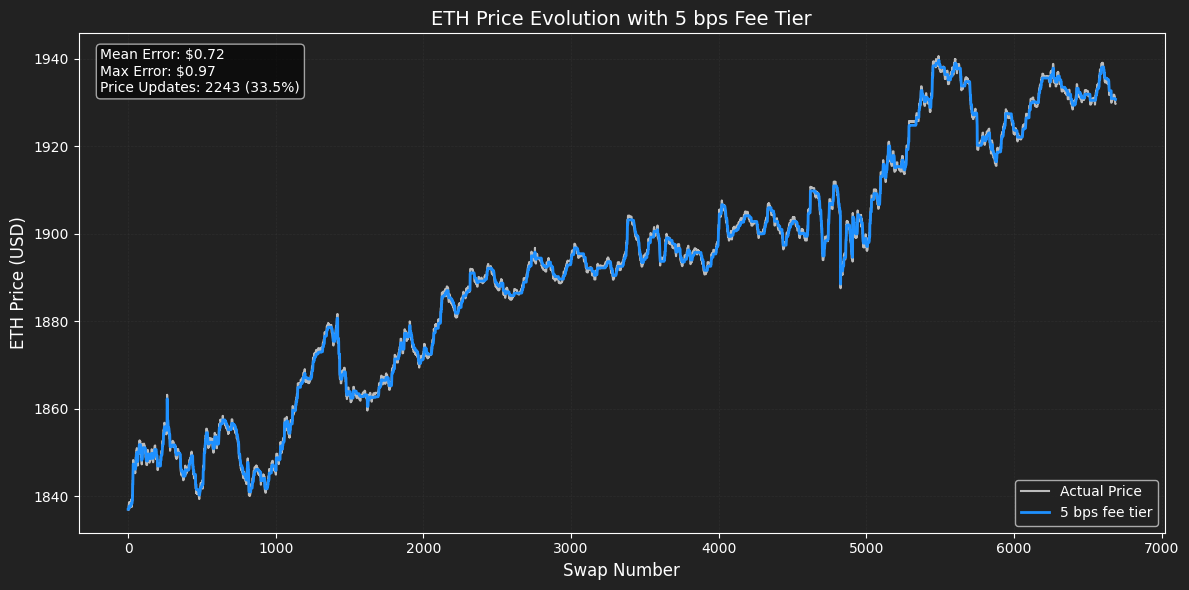

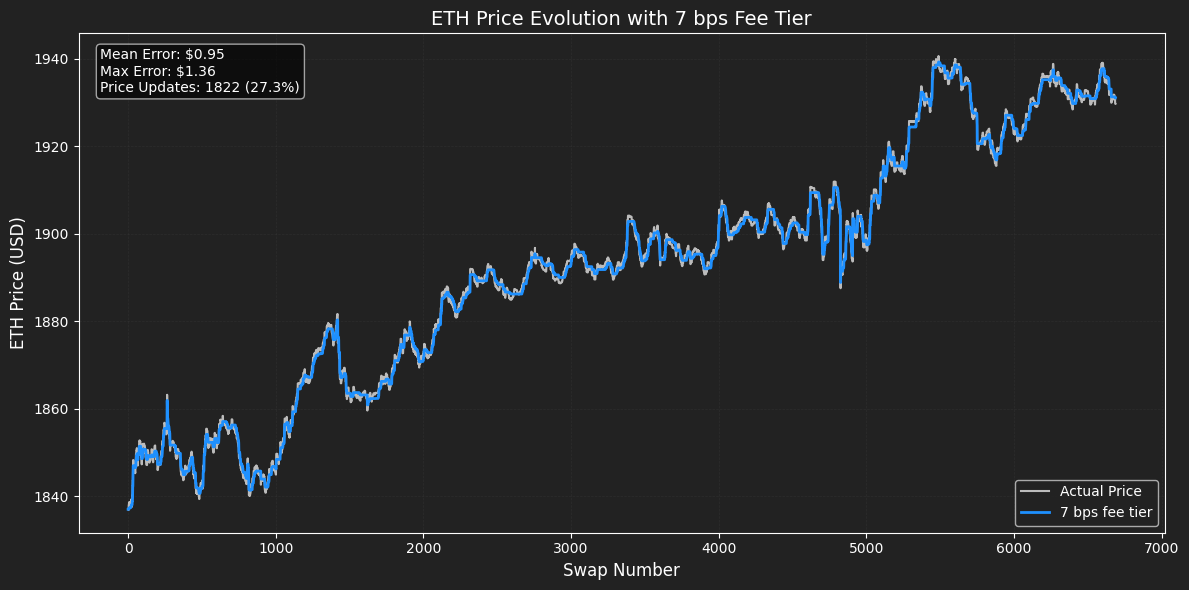

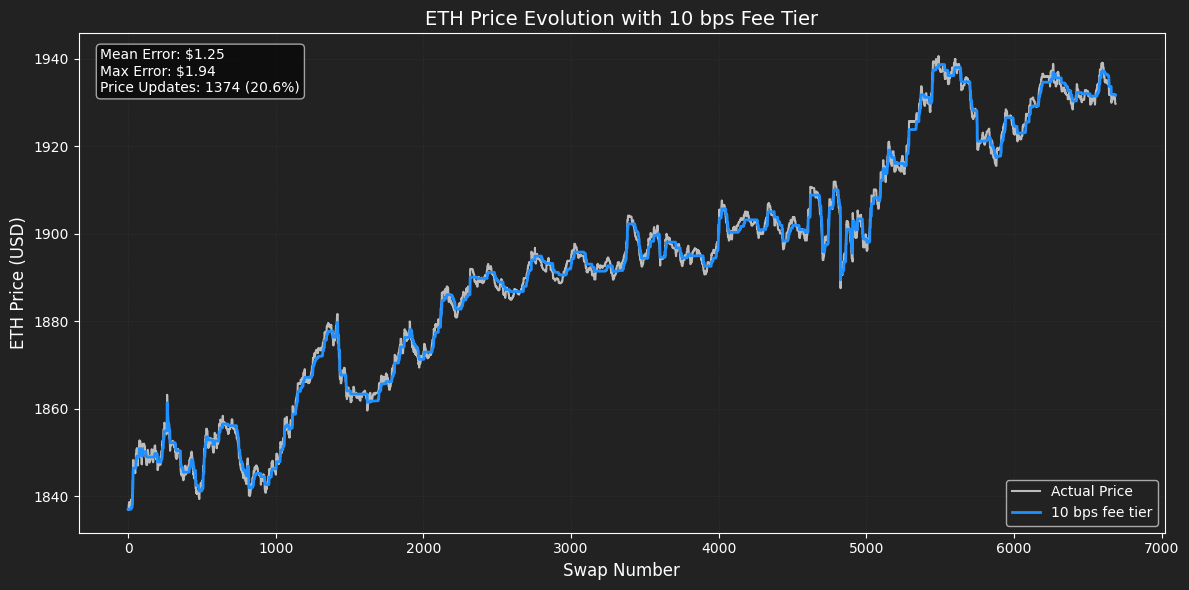

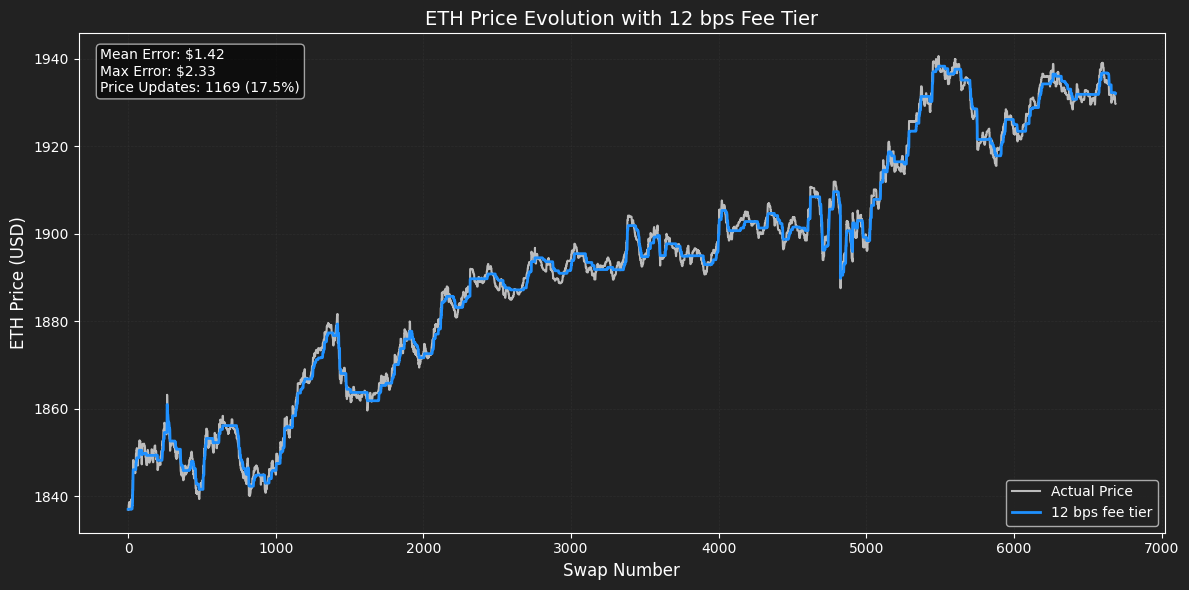

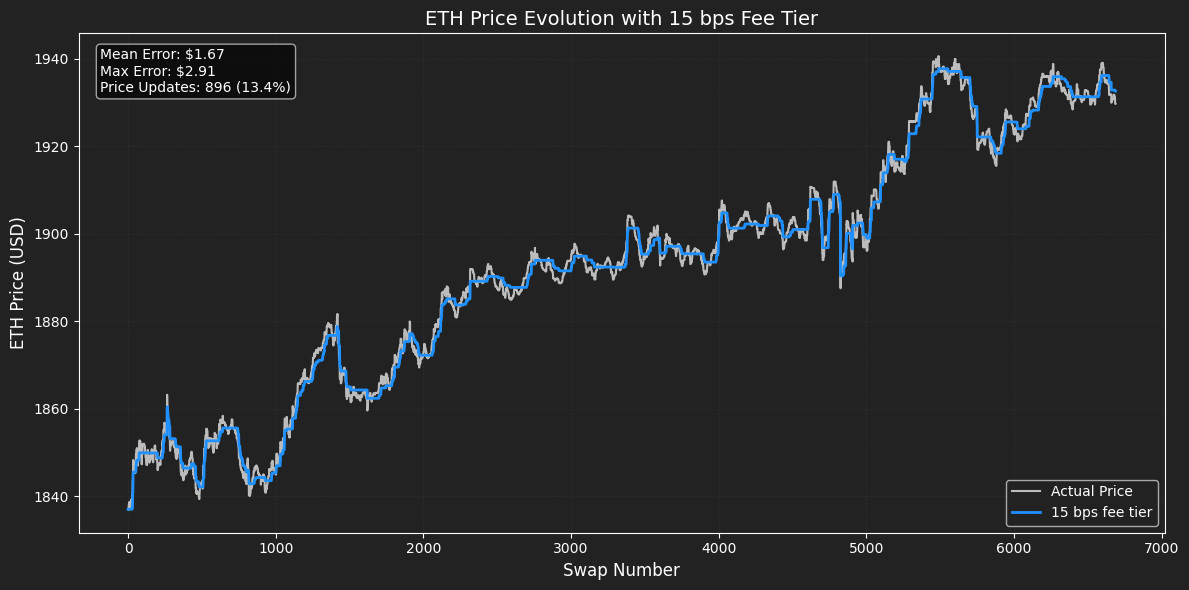

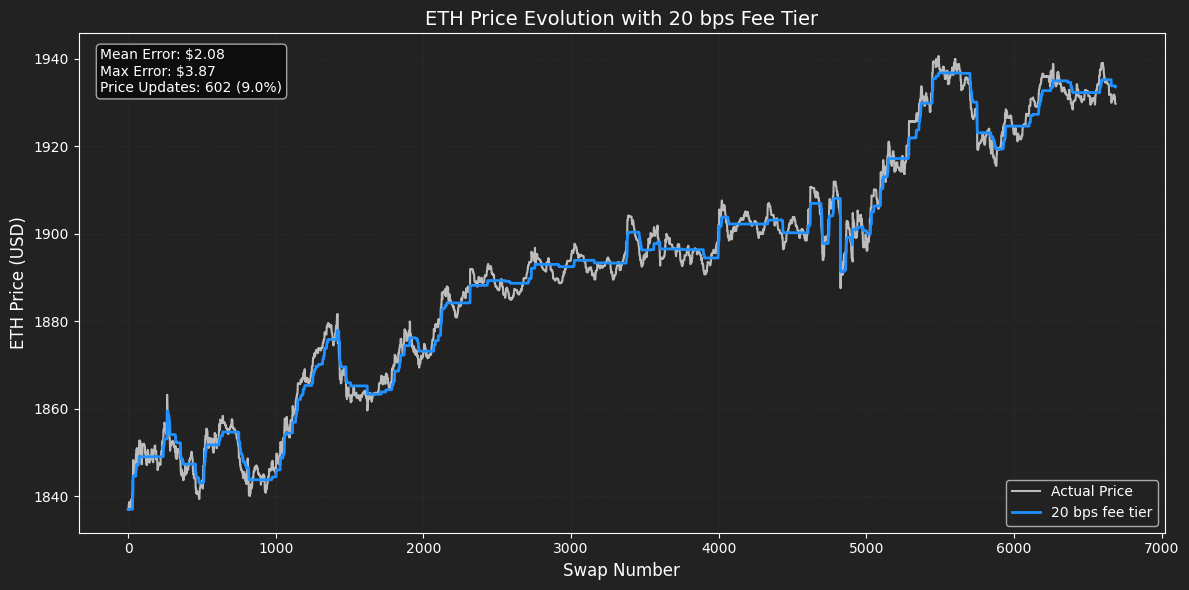

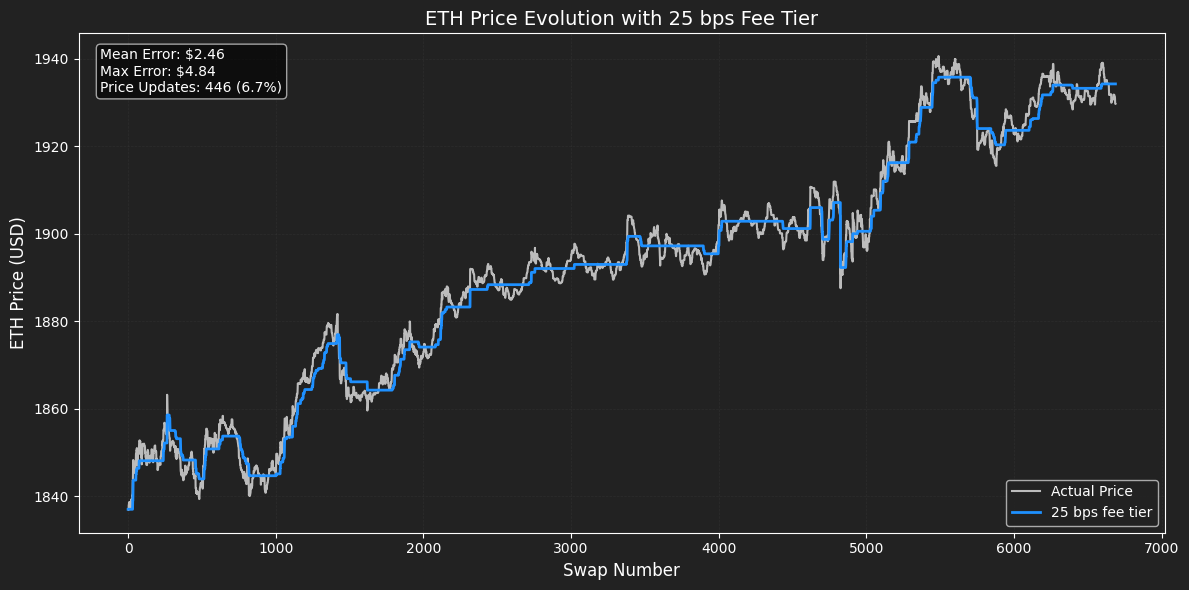

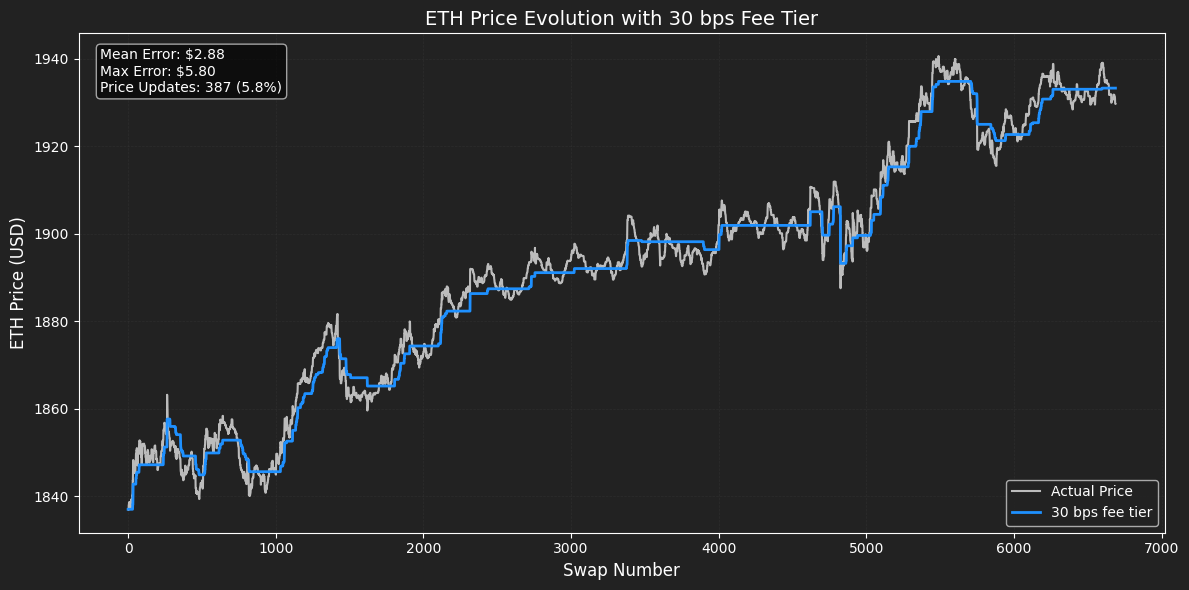

In [3]:
# Load your swap data
swaps_df = load_eth_usdc_swaps("swap_events_1d.csv")
price_df = calculate_prices_from_sqrt_price(swaps_df)

# Add index for plotting
price_df['idx'] = range(len(price_df))
price_df.set_index('idx', inplace=True)

# Plot individual graphs for each fee tier
plot_individual_fee_tier_price_paths(
    price_df, 
    fee_tiers_bps=[5, 7, 10, 12, 15, 20, 25, 30]
)